![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Running MARRMoT M14 model using eWaterCycle package

This notebooks shows how to run [MARRMoT](https://github.com/wknoben/MARRMoT) M14 model using an example use-case. More information about data, configuration and installation instructions can be found in the [System setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) in the eWaterCycle documentation.

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
from rich import print

import ewatercycle.forcing
import ewatercycle.models

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Load forcing data

To download the example forcing file `BMI_testcase_m01_BuffaloRiver_TN_USA.mat`, see this [instruction](https://ewatercycle.readthedocs.io/en/latest/system_setup.html#download-example-forcing).

In [3]:
forcing = ewatercycle.forcing.sources["MarrmotForcing"](
    directory=".",
    start_time="1989-01-01T00:00:00Z",
    end_time="1992-12-31T00:00:00Z",
    forcing_file="BMI_testcase_m01_BuffaloRiver_TN_USA.mat",
)
print(forcing)

MarrmotForcing(
    start_time='1989-01-01T00:00:00Z',
    end_time='1992-12-31T00:00:00Z',
    directory=PosixPath('/home/bart/git/ewatercycle-marrmot/docs'),
    shape=None,
    forcing_file='BMI_testcase_m01_BuffaloRiver_TN_USA.mat'
)

## Set up the model

To create the model object, we provide it with the forcing object:

In [4]:
model = ewatercycle.models.MarrmotM14(forcing=forcing)
print(model)

MarrmotM14(
    parameter_set=None,
    forcing=MarrmotForcing(
        start_time='1989-01-01T00:00:00Z',
        end_time='1992-12-31T00:00:00Z',
        directory=PosixPath('/home/bart/git/ewatercycle-marrmot/docs'),
        shape=None,
        forcing_file='BMI_testcase_m01_BuffaloRiver_TN_USA.mat'
    )
)

The model also has a version. This version is retrieved from the BMI container image.

To run a different version of the model, you can specify the container image:
```py
from ewatercycle.container import ContainerImage

ewatercycle.models.MarrmotM14(
    forcing=forcing,
    bmi_image=ContainerImage("ewatercycle/marrmot-grpc4bmi:2020.11")
)
```

To view the model's version, do:

In [5]:
model.version

'2020.11'

The model's parameters can be accessed using the .parameters property:

In [6]:
print(model.parameters)

dict_items([('maximum_soil_moisture_storage', 1000.0), ('threshold_flow_generation_evap_change', 0.5), 
('leakage_saturated_zone_flow_coefficient', 0.5), ('zero_deficit_base_flow_speed', 100.0), ('baseflow_coefficient',
0.5), ('gamma_distribution_chi_parameter', 4.25), ('gamma_distribution_phi_parameter', 2.5), 
('initial_upper_zone_storage', 900.0), ('initial_saturated_zone_storage', 900.0), ('solver', 
Solver(name='createOdeApprox_IE', resnorm_tolerance=array([0.1]), resnorm_maxiter=array([6.]))), ('start time', 
'1989-01-01T00:00:00Z'), ('end time', '1992-12-31T00:00:00Z')])

Setup model with maximum soil moisture storage of 12.0 instead of 10.0 and an earlier end time, making total model time just 1 month.

In [7]:
cfg_file, cfg_dir = model.setup(
    maximum_soil_moisture_storage=12.0,
    end_time="1989-02-01T00:00:00Z",
)
print(cfg_file)
print(cfg_dir)

/home/bart/git/ewatercycle-marrmot/docs/marrmotm14_20231129_093652/marrmot-m14_config.mat

/home/bart/git/ewatercycle-marrmot/docs/marrmotm14_20231129_093652

In [8]:
print(model.parameters)

dict_items([('maximum_soil_moisture_storage', 12.0), ('threshold_flow_generation_evap_change', 0.5), 
('leakage_saturated_zone_flow_coefficient', 0.5), ('zero_deficit_base_flow_speed', 100.0), ('baseflow_coefficient',
0.5), ('gamma_distribution_chi_parameter', 4.25), ('gamma_distribution_phi_parameter', 2.5), 
('initial_upper_zone_storage', 900.0), ('initial_saturated_zone_storage', 900.0), ('solver', 
Solver(name='createOdeApprox_IE', resnorm_tolerance=array([0.1]), resnorm_maxiter=array([6.]))), ('start time', 
'1989-01-01T00:00:00Z'), ('end time', '1989-02-01T00:00:00Z')])

Initialize the model with the config file:

In [9]:
model.initialize(cfg_file)

Get model variable names, only `flux_out_Q` is supported for now.

In [10]:
model.output_var_names

('P',
 'T',
 'Ep',
 'S(t)',
 'par',
 'sol_resnorm_tolerance',
 'sol_resnorm_maxiter',
 'flux_out_Q',
 'flux_out_Ea',
 'wb')

## Run the model

In [11]:
discharge = []
time_range = []
end_time = model.end_time

while model.time < end_time:
    model.update()
    discharge.append(model.get_value("flux_out_Q")[0])
    time_range.append(model.time_as_datetime.date())

In [12]:
model.finalize()

## Inspect the results

In [13]:
simulated_discharge = pd.DataFrame(
    {"simulation": discharge}, index=pd.to_datetime(time_range)
)

<Axes: >

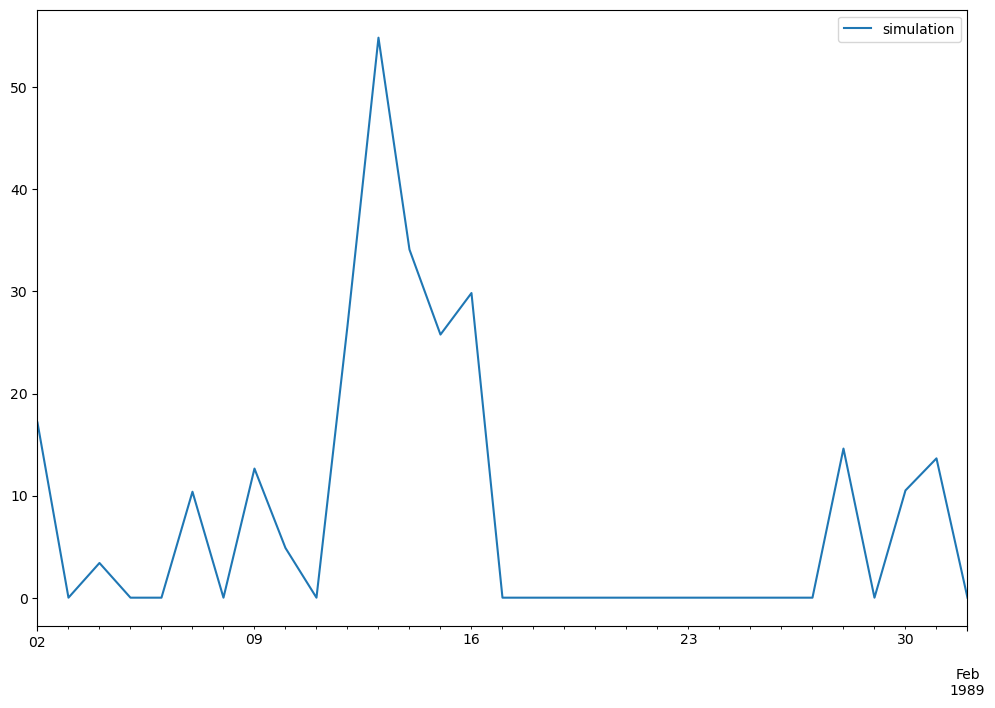

In [14]:
simulated_discharge.plot(figsize=(12, 8))